# Definities

In [1]:
# Basis
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from math import floor, sqrt, pi
from statistics import mean
from glob import glob
import random
import warnings; warnings.filterwarnings('ignore')

# Geo
import geopandas as gp
from geopandas import GeoDataFrame, GeoSeries, sjoin
import shapely
from shapely import wkt
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
import shapely.speedups; shapely.speedups.enable()

# Plot
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors
import matplotlib.animation as animation
import matplotlib.font_manager as font_manager
osfont = font_manager.FontProperties(family='Open Sans', style='normal', size=60)

Er worden verschillende coördinatenreferentiesystemen aangehouden in de gebruikte data. Er moeten ook berekeningen gedaan kunnen worden op de geometrieën (dit kan met cea en lambert). Tot slot kiezen we voor een Amersfoortprojectie voor de kaarten, maar Mercator levert ongeveer hetzelfde eindresultaat. 

In [2]:
# Definieer projecties
crs = {'init': 'epsg:4326'}          # Standaard WGS84
amersfoort = {'init': 'epsg:28992'}  # Rijkscoördinatendriehoek
cea = {'proj':'cea'}                 # Equal area

Definieer bomen

In [79]:
# Oppervlaktes van bomen (m²)
kleine_boom = 10.5
middel_boom = 14.3
grote_boom = 18.7

# Oppervlakte van een microbosje (4 bomen)
tiny_forest_area = grote_boom * 4  # m²
# tiny_forest_area = 280  # m²

# Type bomen, gebaseerd op boomhoogte
lage_bomen = ['tot 6 m', '6-9 m', '9-12 m', 'Onbekend']
midd_bomen = ['12-15 m', '15-18 m']
hoge_bomen = ['18-24 m', '24 m en hoger']

# Minimale afstand voor nieuwe bomen
min_dist = 2.44  # m; dit is de minimale afstand tussen grote bomen
gem_afstand_tot_rand = 2.44  # m; dit is de minimale afstand tot randen

Definieer een aantal functies die voor ons GeoDataFrames maken en willekeurig nieuwe bomen planten.

In [80]:
def to_crs(gdf, crs_out=amersfoort):
    '''Returns a GeoDataFrame with coordinates projected as specified (default epsg:28992)'''
    gdf = gdf.to_crs(crs_out)  # Use geopandas built-in method
    gdf.crs = crs_out  # Set CRS property as well, just to be sure
    return gdf

def create_gdf(df, crs_in=crs, crs_out=amersfoort):
    '''Accepts a DataFrame with a specified CRS (default epsg:4326), 
    and returns a re-projected GeoDataFrame (default epsg:28992)'''
    # Transform Point geometries that are in the wrong format 
    if any(df.geometry.str.contains('POINT')):
        df['geometry'] = df.geometry.str.replace(',', ' ')
    # Transform geometry from text, create GeoDataFrame, and re-project to crs_out
    gdf = GeoDataFrame(df, crs=crs_in, geometry=df.geometry.apply(wkt.loads))
    return to_crs(gdf, crs_out)

def import_csv(csv, crs_in=crs, crs_out=amersfoort):
    '''Accepts a csv file and returns a GeoDataFrame'''
    df = pd.read_csv(csv, dtype=str, sep=';').drop(columns=['OBJECTNUMMER', 'WKT_LAT_LNG', 'LNG', 'LAT'])
    df = df[df.columns.drop(df.filter(regex='Unnamed').columns)].rename(columns={'WKT_LNG_LAT':'geometry'})
    return create_gdf(df, crs_in, crs_out)

def calc_area(gdf, m=False, crs_out=amersfoort):
    '''Adds a new column to a GeoDataFrame that contains the surface area in km² (or m² if m=True) of its geometries'''
    gdf = to_crs(gdf, cea)  # Use equal areas to make area calculations
    if not m:
        m = 10**6  # Re-calculate to km²
    gdf['oppervlakte'] = gdf.geometry.area / m
    return to_crs(gdf, crs_out)

def random_points_within(poly, k, min_dist=min_dist, gem_afstand_tot_rand=gem_afstand_tot_rand, k_max=10, buffer=0):
    '''Returns a list of lists of k random Point objects that are within poly, seperated by at least min_dist'''
    min_x, min_y, max_x, max_y = poly.bounds
    points, p, e = [], [], []
    i = 0
    while len(points) < k:
        i += 1
        # Pak een random punt op de x-as, en vind en een random punt op de y-as dat in het polygoon ligt
#         try:
#             x = random.uniform(min_x, max_x)
#             x_line = LineString([(x, min_y), (x, max_y)])
#             x_line_intercept_min, x_line_intercept_max = x_line.intersection(poly.buffer(buffer)).xy[1].tolist()
#             y = random.uniform(x_line_intercept_min, x_line_intercept_max)
#         except NotImplementedError:
#             if not isinstance(e, str):
#                 e = 'Trouble finding points in poly; try increasing buffer.'
#                 print(e)
#             continue
#         point = Point([x, y])
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        # Controleer of het punt in de poly ligt, anders opnieuw proberen
        if point.within(poly):
            pass
        else:
            continue
        # Controleer of de afstand van een nieuwe boom tot bestaande bomen kleiner is dan min_dist
        # (Dit werkt nog niet goed wanneer min_dist te groot is)
        dist = []
        gdf = GeoDataFrame(points, crs=cea)
        for ind in range(len(gdf)):
            dist.append(gdf.iat[ind, 0].distance(point) < min_dist)  # bool
        # Voeg de nieuwe boom toe, behalve als er een andere nieuwe boom dichterbij ligt dan min_dist
        # en behalve als de boom te dicht bij de rand van het polygoon ligt (default 0)
        try:
            if sum(dist) == 0 and poly.exterior.distance(point) < gem_afstand_tot_rand:
                points.append(point)
            elif i > k * k_max:
#                 if not isinstance(p):
#                     p = 'Trouble finding points in poly; try adjusting parameters.'
#                     print(p)
                return points
            else:
                continue
        except:
            if sum(dist) == 0:
                points.append(point)
            elif i > k * k_max:
#                 if not isinstance(p, str):
#                     p = 'Trouble finding points in poly; try adjusting parameters.'
#                     print(p)
                return points
            else:
                continue
    return points

def random_points(row, length, colname='nieuwe_bomen', min_dist=min_dist, k_max=10, buffer=0):
    '''Returns a list of lists of random points, 
    based on a geometry and a value of nieuwe_bomen in a GeoDataFrame'''
    print(f'{row.name}')
    points = random_points_within(row['geometry'], row[colname], min_dist=min_dist, k_max=k_max, buffer=buffer)
    return points

def plant_trees(gdf, colname='nieuwe_bomen', min_dist=min_dist, k_max=10, buffer=0):
    '''Returns a GeoSeries (with epsg:28992) of random points within each geometry of a GeoDataFrame'''
    # change gdf.crs to cea for equal area calculations 
    # get a list of lists of random points within gdf.geometry
    # transform into a Series, then a GeoSeries, and change crs to epsg:28992
    return to_crs(GeoSeries(pd.Series(to_crs(gdf, cea).apply(
        random_points, length=len(gdf), colname=colname, min_dist=min_dist, k_max=k_max, buffer=buffer, 
        axis=1)).apply(lambda x: pd.Series(x)).stack().tolist(), crs=cea), amersfoort)


# Gebieden en Bomen

In [9]:
# Importeer stadsdelen
sd = import_csv('data/020/GEBIED_STADSDELEN.csv')#_EXWATER.csv')
sd = calc_area(sd)  # Voeg een kolom toe met oppervlakte per stadsdeel

# Importeer buurten
buurten = import_csv('data/020/GEBIED_BUURTEN.csv').rename(index=str, columns={'Buurt_code': 'Buurtcode'})

# We laten de buurt Waterland en grote delen van Westpoort buiten beschouwing
buurten = buurten[buurten.Buurtcombinatie_code != 'N73']
buurten = buurten[~buurten.Buurtcode.isin(['B10a', 'B10c', 'B10d', 'B10e', 'B10f', 'B10g', 'B10h'])]
buurten = buurten.merge(sd[['Stadsdeel_code', 'Stadsdeel']], on='Stadsdeel_code', how='left')

# En om te plotten:
plot_buurten = import_csv('data/020/GEBIED_BUURTEN_EXWATER.csv').rename(index=str, columns={'Buurt_code': 'Buurtcode'})
plot_buurten = plot_buurten[plot_buurten.Buurtcombinatie_code != 'N73']
plot_buurten = plot_buurten[~plot_buurten.Buurtcode.isin(['B10a', 'B10c', 'B10d', 'B10e', 'B10f', 'B10g', 'B10h'])]
plot_buurten = plot_buurten.merge(sd[['Stadsdeel_code', 'Stadsdeel']], on='Stadsdeel_code', how='left')


# Importeren en samenvoegen van de vier .csv-bestanden
bomen = pd.concat([pd.read_csv(file, sep=';', usecols=['Soortnaam_NL', 'Boomnummer', 'Boomtype', 'Boomhoogte', 'WKT_LNG_LAT']) 
                   for file in glob('data\BOMEN*.csv')], axis=0, ignore_index=True).rename(columns={'WKT_LNG_LAT':'geometry'})

# Elke boom heeft een aantal van 1, dit gebruiken we later
bomen['aantal_bomen'] = 1

# Kolom toevoegen met boomoppervlakte (in m²) op basis van de boomhoogte
bomen['boomoppervlakte'] = np.where(bomen['Boomhoogte'].isin(lage_bomen), kleine_boom, 
                                    np.where(bomen['Boomhoogte'].isin(hoge_bomen), grote_boom, middel_boom))
bomen['radius'] = np.sqrt(bomen.boomoppervlakte.values / pi)

# Maak van bomen een fatsoenlijk GeoDataFrame
bomen = create_gdf(bomen)  # crs=amersfoort, zie functie hierboven
bomen = sjoin(bomen, buurten, op='within').drop(columns=['index_right'])

# Voeg Polygons toe, deze worden later gebruikt voor ruimteberekeningen
bomen['polygons'] = GeoSeries(bomen.apply(lambda x: x.geometry.buffer(x.radius), axis=1), crs=amersfoort)

# Wegen

In [33]:
gdf = pd.read_csv('final/gdf_final.csv', index_col=0)
gdf = GeoDataFrame(gdf, crs=amersfoort, geometry=gdf.geometry.apply(wkt.loads))

Even wat nummers:

In [ ]:
# Hoeveel bomen kunnen we planten? 
groot = gdf.grote_bomen.sum().astype(int)
middel = gdf.middel_bomen.sum().astype(int)
klein = gdf.kleine_bomen.sum().astype(int)
print(
    f'Er kunnen {(gdf.nieuwe_bomen.sum() / 4).astype(int):,} microbosjes ({gdf.nieuwe_bomen.sum().astype(int):,} bomen) geplant worden in Amsterdam.\n'
#       f'Deze kunnen bestaan uit {groot:,} grote, {middel:,} middel, en {klein:,} kleine bomen.'
)

In [ ]:
gdf[['aantal_bomen', 'oorspr_opp_wegdeel', 'oorspr_opp_wegdeel_buurt', 'oppervlakte', 'percentage_if_bomen', 
     'ruimte', 'nieuwe_bomen']].reset_index(drop=True)

In [ ]:
gdf[gdf.Stadsdeel=='Centrum'].nieuwe_bomen.sum()

In [ ]:
# Top 10 buurten
gdf[['Buurt', 'nieuwe_bomen']].groupby('Buurt').sum().sort_values('nieuwe_bomen', ascending=False).head(10)

# MasterPlot Centrum

In [ ]:
nieuwe_bomen = plant_trees(gdf[gdf.Stadsdeel == 'Centrum'], min_dist=2.44)

In [ ]:
nieuwe_bomen.reset_index().to_csv('Centrum_nieuwe_bomen.csv', header=['index', 'geometry'], index=False)

In [39]:
nieuwe_bomen = pd.read_csv('Centrum_nieuwe_bomen.csv', index_col=0)
nieuwe_bomen = GeoDataFrame(nieuwe_bomen, crs=amersfoort, geometry=nieuwe_bomen.geometry.apply(wkt.loads))

In [ ]:
fig, ax = plt.subplots(1, figsize=(60, 80))
plt.axis('off')

# Plot the geometries
plot_buurten[plot_buurten.Stadsdeel == 'Centrum'].plot(ax=ax, color='white', edgecolor='darkslategrey', linewidth=1)
gdf[gdf.Stadsdeel == 'Centrum'].plot(ax=ax, color='Black', alpha=0.3)

# Legend
leg_0 = patches.Patch(
    color='black', alpha=0.3, 
    label=f"Roads")
plt.legend(handles=[leg_0], prop=osfont, fancybox=True)

plt.show();

fig.savefig('Centrum roadmap.png', bbox_inches='tight')
fig.savefig('Centrum roadmap.pdf', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1, figsize=(60, 80))
plt.axis('off')

# Plot the geometries
plot_buurten[plot_buurten.Stadsdeel == 'Centrum'].plot(ax=ax, color='white', edgecolor='darkslategrey', linewidth=1)
gdf[gdf.Stadsdeel == 'Centrum'].plot(ax=ax, color='Black', alpha=0.3)
bomen[bomen.Stadsdeel == 'Centrum'].plot(ax=ax, color='#2ca02c', markersize=100)

# Legend
leg_0 = patches.Patch(
    color='black', alpha=0.3, 
    label=f"Roads")
leg_1 = patches.Patch(
    color='#2ca02c', 
    label=f"Existing Trees ({bomen[bomen.Stadsdeel == 'Centrum'].aantal_bomen.sum():,})")
plt.legend(handles=[leg_0, leg_1], prop=osfont, fancybox=True)

plt.show();

fig.savefig('Centrum existing trees.png', bbox_inches='tight')
fig.savefig('Centrum existing trees.pdf', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1, figsize=(60, 80))
plt.axis('off')

# Plot the geometries
plot_buurten[plot_buurten.Stadsdeel == 'Centrum'].plot(ax=ax, color='white', edgecolor='darkslategrey', linewidth=1)
gdf[gdf.Stadsdeel == 'Centrum'].plot(ax=ax, color='silver', alpha=.8)
bomen[bomen.Stadsdeel == 'Centrum'].plot(ax=ax, color='#2ca02c', markersize=100)
nieuwe_bomen.plot(ax=ax, color='#d62728', markersize=1000)

# Legend
leg_0 = patches.Patch(
    color='silver', alpha=.8,  
    label=f"Roads")
leg_1 = patches.Patch(
    color='#2ca02c', 
    label=f"Existing Trees ({bomen[bomen.Stadsdeel == 'Centrum'].aantal_bomen.sum():,})")
leg_2 = patches.Patch(
    color='#d62728', 
    label=f"Potential Trees ({len(nieuwe_bomen):,})")
plt.legend(handles=[leg_0, leg_1, leg_2], prop=osfont, fancybox=True)

plt.show();

fig.savefig('Centrum potential trees (no layers).png', bbox_inches='tight')
# fig.savefig('Centrum potential trees.pdf', bbox_inches='tight')

# Verkrijg data om nieuwe_bomen vs min_dist en tiny_forest_area te plotten

In [ ]:
gdf_all = gdf.copy()

gdf = gdf[gdf.Stadsdeel == 'Centrum']
gdf = gdf[['ruimte', 'nieuwe_bomen', 'geometry']]

tiny_forest_area = list(range(20, 400, 10))
min_dist = [0.5, 1, 1.5, 1.83, 2.44, 4.5]
potential_trees = pd.Series(np.nan, 
                            pd.MultiIndex.from_arrays(
                                np.array([np.repeat(min_dist, len(tiny_forest_area)), 
                                          np.array([tiny_forest_area for x in range(len(min_dist))]).reshape((228,))]), 
                                names=('min_dist', 'tiny_forest_area')))

for md in min_dist:
    for tfa in tiny_forest_area:
        gdf['nieuwe_bomen'] = (gdf.ruimte / (tfa / 4))
        gdf['nieuwe_bomen'] = gdf.nieuwe_bomen.round().where(~gdf.nieuwe_bomen.isna(), 0).astype(int)
        potential_trees.loc[md, tfa] = len(plant_trees(gdf, min_dist=md))
potential_trees.reset_index().to_csv('potential_trees.csv', index=False)

gdf = gdf_all.copy()
del gdf_all

# MasterPlot Amsterdam

In [ ]:
nieuwe_bomen = plant_trees(gdf, min_dist=2.44)
nieuwe_bomen.to_csv('nieuwe_bomen_heel_Amsterdam.csv')
len(nieuwe_bomen)

In [ ]:
fig, ax = plt.subplots(1, figsize=(60, 80))
plt.axis('off')

# Plot the geometries
plot_buurten.plot(ax=ax, color='white', edgecolor='darkslategrey', linewidth=1)
gdf.plot(ax=ax, color='Black', alpha=0.3)

# Legend
leg_0 = patches.Patch(
    color='black', alpha=0.3, 
    label=f"Roads")
plt.legend(handles=[leg_0], prop=osfont, fancybox=True)

plt.show();

fig.savefig('Amsterdam roadmap.png', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1, figsize=(60, 80))
plt.axis('off')

# Plot the geometries
plot_buurten.plot(ax=ax, color='white', edgecolor='darkslategrey', linewidth=1)
gdf.plot(ax=ax, color='Black', alpha=0.3)
bomen.plot(ax=ax, color='#2ca02c', markersize=10)

# Legend
leg_0 = patches.Patch(
    color='black', alpha=0.3, 
    label=f"Roads")
leg_1 = patches.Patch(
    color='#2ca02c', 
    label=f"Existing Trees ({bomen.aantal_bomen.sum():,})")
plt.legend(handles=[leg_0, leg_1], prop=osfont, fancybox=True)

plt.show();

fig.savefig('Amsterdam existing trees.png', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1, figsize=(60, 80))
plt.axis('off')

# Plot the geometries
plot_buurten.plot(ax=ax, color='white', edgecolor='darkslategrey', linewidth=1)
gdf.plot(ax=ax, color='Black', alpha=0.3)
bomen.plot(ax=ax, color='#2ca02c', markersize=10)
nieuwe_bomen.plot(ax=ax, color='#d62728', markersize=40)

# Legend
leg_0 = patches.Patch(
    color='black', alpha=0.3, 
    label=f"Roads")
leg_1 = patches.Patch(
    color='#2ca02c', 
    label=f"Existing Trees ({bomen.aantal_bomen.sum():,})")
leg_2 = patches.Patch(
    color='#d62728', 
    label=f"Potential Trees ({len(nieuwe_bomen):,})")
plt.legend(handles=[leg_0, leg_1, leg_2], prop=osfont, fancybox=True)

plt.show();

fig.savefig('Amsterdam potential trees.png', bbox_inches='tight')

# 10.000 parkeerplaatsen

In [ ]:
tmp = gdf[gdf.function == 'parkeervlak'].copy()
tmp = tmp[~(tmp.Stadsdeel.isin(['Noord', 'Nieuw-West', 'Zuidoost'])) & ~(tmp.Buurtcombinatie_code == 'E12') & ~(tmp.Buurtcode.isin(['E36b', 'E39b', 'E39c', 'E39d', 'K44f']))]
tmp['parkeervlak'] = 1
tmp[['Stadsdeel', 'parkeervlak']].groupby('Stadsdeel').sum()
# tmp = tmp.drop(columns=['parkeervlak']).merge(tmp[['Buurtcode', 'parkeervlak']].groupby('Buurtcode').sum().reset_index())
# tmp = tmp.groupby('Buurtcode').apply(lambda s: s.sample(min(int(10000/len(tmp.Buurtcode.unique())), s.parkeervlak)))

In [ ]:
tmp = pd.concat([tmp[tmp.Stadsdeel == 'Centrum'], 
                 tmp[(tmp.Buurtcombinatie_code.isin([
                     'M27', 'M28', 'M29', 'M30', 'M31', 'M32'])) | (tmp.Buurtcode.isin([
                     'M56a', 'M56b', 'M58b', 'M58h']))].sample(int((10000-4872)/3)), 
                 tmp[tmp.Stadsdeel == 'West'].sample(int((10000-4872)/3) + 1), 
                 tmp[(tmp.Buurtcombinatie_code.isin([
                     'K24', 'K25', 'K26', 'K44', 'K45', 'K46', 'K47', 'K52', 'K53', 'K54'])) | 
                     (tmp.Buurtcode == 'K23b')].sample(int((10000-4872)/3))])
tmp['geometry'] = tmp.geometry.representative_point()
tmp[['Stadsdeel', 'parkeervlak']].groupby('Stadsdeel').sum()

In [ ]:
fig, ax = plt.subplots(1, figsize=(60, 80))
plt.axis('off')

# Plot the geometries
plot_buurten[~plot_buurten.Stadsdeel.isin(['Noord', 'Nieuw-West', 'Zuidoost']) & ~(plot_buurten.Buurtcombinatie_code == 'E12') & ~(plot_buurten.Buurtcode.isin(['E36b', 'E39b', 'E39c', 'E39d', 'K44f'])) & ((plot_buurten.Stadsdeel.isin(['Centrum', 'West'])) | (plot_buurten.Buurtcombinatie_code.isin(['M27', 'M28', 'M29', 'M30', 'M31', 'M32', 'K24', 'K25', 'K26', 'K44', 'K45', 'K46', 'K47', 'K52', 'K53', 'K54'])) | (plot_buurten.Buurtcode.isin(['M56a', 'M56b', 'M58b', 'M58h', 'K23b'])))]\
.plot(ax=ax, color='white', edgecolor='darkslategrey', linewidth=1)

gdf[~gdf.Stadsdeel.isin(['Noord', 'Nieuw-West', 'Zuidoost']) & ~(gdf.Buurtcombinatie_code == 'E12') & ~(gdf.Buurtcode.isin(['E36b', 'E39b', 'E39c', 'E39d', 'K44f'])) & ((gdf.Stadsdeel.isin(['Centrum', 'West'])) | (gdf.Buurtcombinatie_code.isin(['M27', 'M28', 'M29', 'M30', 'M31', 'M32', 'K24', 'K25', 'K26', 'K44', 'K45', 'K46', 'K47', 'K52', 'K53', 'K54'])) | (gdf.Buurtcode.isin(['M56a', 'M56b', 'M58b', 'M58h', 'K23b'])))]\
.plot(ax=ax, color='Black', alpha=0.3)

bomen[~bomen.Stadsdeel.isin(['Noord', 'Nieuw-West', 'Zuidoost']) & ~(bomen.Buurtcombinatie_code == 'E12') & ~(bomen.Buurtcode.isin(['E36b', 'E39b', 'E39c', 'E39d', 'K44f'])) & ((bomen.Stadsdeel.isin(['Centrum', 'West'])) | (bomen.Buurtcombinatie_code.isin(['M27', 'M28', 'M29', 'M30', 'M31', 'M32', 'K24', 'K25', 'K26', 'K44', 'K45', 'K46', 'K47', 'K52', 'K53', 'K54'])) | (bomen.Buurtcode.isin(['M56a', 'M56b', 'M58b', 'M58h', 'K23b'])))]\
.plot(ax=ax, color='#2ca02c', markersize=40)

# Legend
leg_0 = patches.Patch(
    color='black', alpha=0.3, 
    label=f"Roads")
leg_1 = patches.Patch(
    color='#2ca02c', 
    label=f"Existing Trees ({bomen[~bomen.Stadsdeel.isin(['Noord', 'Nieuw-West', 'Zuidoost']) & ~(bomen.Buurtcombinatie_code == 'E12') & ~(bomen.Buurtcode.isin(['E36b', 'E39b', 'E39c', 'E39d', 'K44f'])) & ((bomen.Stadsdeel.isin(['Centrum', 'West'])) | (bomen.Buurtcombinatie_code.isin(['M27', 'M28', 'M29', 'M30', 'M31', 'M32', 'K24', 'K25', 'K26', 'K44', 'K45', 'K46', 'K47', 'K52', 'K53', 'K54'])) | (bomen.Buurtcode.isin(['M56a', 'M56b', 'M58b', 'M58h'])))].aantal_bomen.sum():,})")
leg_2 = patches.Patch(
    color='#d62728', 
    label=f"Potential Trees ({len(tmp):,})")
plt.legend(handles=[leg_0, leg_1], prop=osfont, fancybox=True)

plt.show();

fig.savefig('Amsterdam parking spots 1.png', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1, figsize=(60, 80))
plt.axis('off')

# Plot the geometries
plot_buurten[~plot_buurten.Stadsdeel.isin(['Noord', 'Nieuw-West', 'Zuidoost']) & ~(plot_buurten.Buurtcombinatie_code == 'E12') & ~(plot_buurten.Buurtcode.isin(['E36b', 'E39b', 'E39c', 'E39d', 'K44f'])) & ((plot_buurten.Stadsdeel.isin(['Centrum', 'West'])) | (plot_buurten.Buurtcombinatie_code.isin(['M27', 'M28', 'M29', 'M30', 'M31', 'M32', 'K24', 'K25', 'K26', 'K44', 'K45', 'K46', 'K47', 'K52', 'K53', 'K54'])) | (plot_buurten.Buurtcode.isin(['M56a', 'M56b', 'M58b', 'M58h', 'K23b'])))]\
.plot(ax=ax, color='white', edgecolor='darkslategrey', linewidth=1)

gdf[~gdf.Stadsdeel.isin(['Noord', 'Nieuw-West', 'Zuidoost']) & ~(gdf.Buurtcombinatie_code == 'E12') & ~(gdf.Buurtcode.isin(['E36b', 'E39b', 'E39c', 'E39d', 'K44f'])) & ((gdf.Stadsdeel.isin(['Centrum', 'West'])) | (gdf.Buurtcombinatie_code.isin(['M27', 'M28', 'M29', 'M30', 'M31', 'M32', 'K24', 'K25', 'K26', 'K44', 'K45', 'K46', 'K47', 'K52', 'K53', 'K54'])) | (gdf.Buurtcode.isin(['M56a', 'M56b', 'M58b', 'M58h', 'K23b'])))]\
.plot(ax=ax, color='Black', alpha=0.3)

bomen[~bomen.Stadsdeel.isin(['Noord', 'Nieuw-West', 'Zuidoost']) & ~(bomen.Buurtcombinatie_code == 'E12') & ~(bomen.Buurtcode.isin(['E36b', 'E39b', 'E39c', 'E39d', 'K44f'])) & ((bomen.Stadsdeel.isin(['Centrum', 'West'])) | (bomen.Buurtcombinatie_code.isin(['M27', 'M28', 'M29', 'M30', 'M31', 'M32', 'K24', 'K25', 'K26', 'K44', 'K45', 'K46', 'K47', 'K52', 'K53', 'K54'])) | (bomen.Buurtcode.isin(['M56a', 'M56b', 'M58b', 'M58h', 'K23b'])))]\
.plot(ax=ax, color='#2ca02c', markersize=40)

tmp.plot(ax=ax, color='#d62728', markersize=100)

# Legend
leg_0 = patches.Patch(
    color='black', alpha=0.3, 
    label=f"Roads")
leg_1 = patches.Patch(
    color='#2ca02c', 
    label=f"Existing Trees ({bomen[~bomen.Stadsdeel.isin(['Noord', 'Nieuw-West', 'Zuidoost']) & ~(bomen.Buurtcombinatie_code == 'E12') & ~(bomen.Buurtcode.isin(['E36b', 'E39b', 'E39c', 'E39d', 'K44f'])) & ((bomen.Stadsdeel.isin(['Centrum', 'West'])) | (bomen.Buurtcombinatie_code.isin(['M27', 'M28', 'M29', 'M30', 'M31', 'M32', 'K24', 'K25', 'K26', 'K44', 'K45', 'K46', 'K47', 'K52', 'K53', 'K54'])) | (bomen.Buurtcode.isin(['M56a', 'M56b', 'M58b', 'M58h'])))].aantal_bomen.sum():,})")
leg_2 = patches.Patch(
    color='#d62728', 
    label=f"Potential Trees ({len(tmp):,})")
plt.legend(handles=[leg_0, leg_1, leg_2], prop=osfont, fancybox=True)

plt.show();

fig.savefig('Amsterdam parking spots 2.png', bbox_inches='tight')

# Ontdek dubbele geometriën

In [7]:
tmp = gdf[['geometry', 'function', 'aantal_bomen', 'oorspr_opp_wegdeel_buurt', 'oorspr_opp_wegdeel', 'oppervlakte', 
           'Stadsdeel', 'Buurt']].copy()
tmp = tmp[(tmp.aantal_bomen > 0) | (tmp.function.isin([
    'berm', 'inrit', 'parkeervlak', 'transitie', 'verkeersdrempel', 'verkeerseiland', 'voetgangersgebied', 
    'voetpad', 'voetpad op trap', 'woonerf', ]))].drop(columns=['function'])
# tmp['tmpopp'] = tmp.geometry.area
# tmp = tmp[tmp.tmpopp != 0]
# tmp = tmp[~tmp.geometry.astype(str).str.contains('LINESTRING')]
tmp['geometry'] = tmp.geometry.buffer(0.01)
tmp = tmp.dissolve('Buurt', aggfunc='sum')
# tmp.geometry.area.sum()

In [102]:
tmp = calc_area(tmp.rename(columns={'oppervlakte': 'opp_voor_dissolve'}), m=True)

In [108]:
tmp['ruimte'] = tmp.oppervlakte * ((0.175 - ((tmp.oorspr_opp_wegdeel_buurt - tmp.opp_voor_dissolve) / tmp.oorspr_opp_wegdeel_buurt)))
tmp.loc[tmp.ruimte < 0, 'ruimte'] = 0
tmp['nieuwe_bomen'] = (tmp.ruimte / (tiny_forest_area / 4))
tmp['nieuwe_bomen'] = tmp.nieuwe_bomen.round().where(~tmp.nieuwe_bomen.isna(), 0).astype(int)

In [110]:
tmp.to_csv('dissolved_by_buurt.csv')

In [6]:
tmp = pd.read_csv('dissolved_by_buurt.csv', index_col=0)
tmp = GeoDataFrame(tmp, crs=amersfoort, geometry=tmp.geometry.apply(wkt.loads))

In [81]:
tmp_potential_trees = plant_trees(tmp[tmp.index.isin(buurten[buurten.Stadsdeel == 'Centrum'].Buurt.tolist())], buffer=50)

Alexanderplein e.o.
Amstelveldbuurt
Anjeliersbuurt Noord
Anjeliersbuurt Zuid
BG-terrein e.o.
Begijnhofbuurt
Bloemgrachtbuurt
Burgwallen Oost
Czaar Peterbuurt
Den Texbuurt
Driehoekbuurt
Elandsgrachtbuurt
Felix Meritisbuurt
Frederikspleinbuurt
Gouden Bocht
Groenmarktkadebuurt
Haarlemmerbuurt Oost
Haarlemmerbuurt West
Hemelrijk
Het Funen
Kadijken
Kalverdriehoek
Kattenburg
Kazernebuurt
Kop Zeedijk
Langestraat e.o.
Lastage
Leidsebuurt Noordoost
Leidsebuurt Noordwest
Leidsebuurt Zuidoost
Leidsebuurt Zuidwest
Leidsegracht Noord
Leidsegracht Zuid
Leliegracht e.o.
Marine-Etablissement
Marnixbuurt Midden
Marnixbuurt Noord
Marnixbuurt Zuid
Nes e.o.
Nieuwe Kerk e.o.
Nieuwendijk Noord
Nieuwmarkt
Oostenburg
Oosterdokseiland
Oude Kerk e.o.
Passeerdersgrachtbuurt
Planciusbuurt Noord
Planciusbuurt Zuid
Plantage
Rapenburg
Reguliersbuurt
Rembrandtpleinbuurt
Sarphatistrook
Scheepvaarthuisbuurt
Spiegelbuurt
Spuistraat Noord
Spuistraat Zuid
Stationsplein e.o.
Uilenburg
Utrechtsebuurt Zuid
Valkenburg
Van Loo

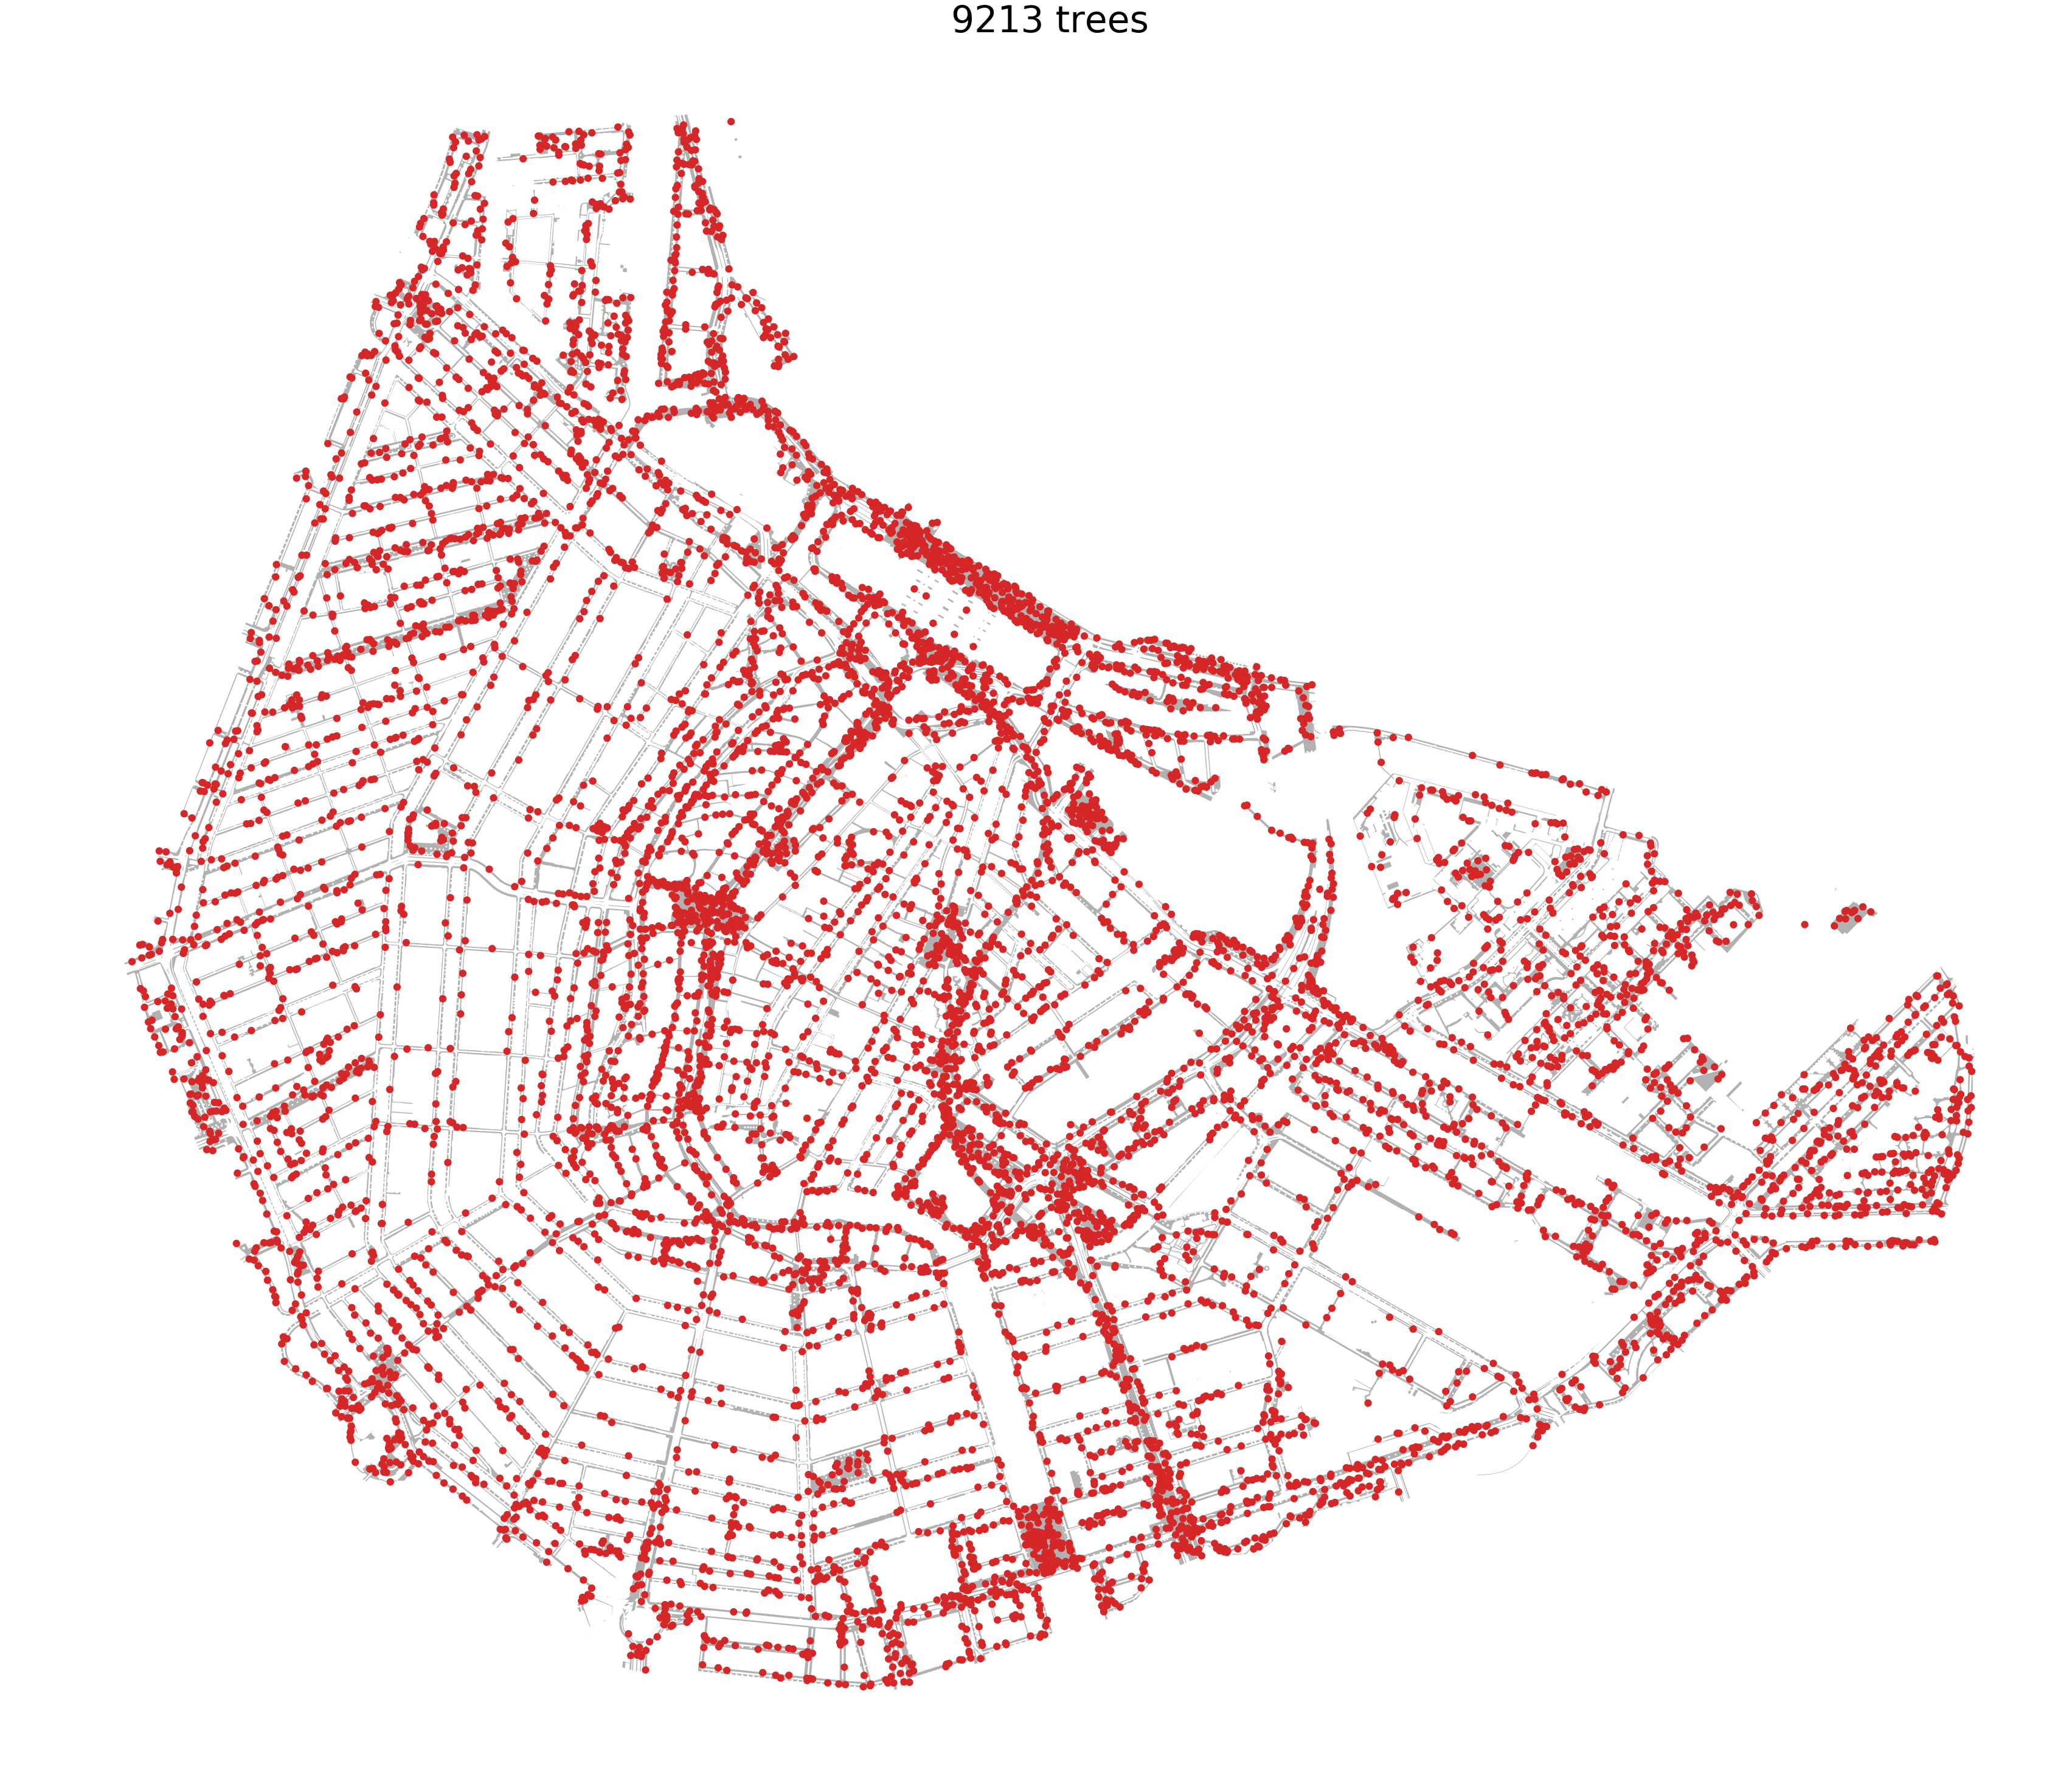

In [82]:
fig, ax = plt.subplots(1, figsize=(60, 80))
plt.axis('off')
tmp[tmp.index.isin(buurten[buurten.Stadsdeel == 'Centrum'].Buurt.tolist())].plot(ax=ax, color='black', alpha=.3)
tmp_potential_trees.buffer(8).plot(ax=ax, color='#d62728')
plt.title(f'{len(tmp_potential_trees)} trees', size=60)
plt.show();
fig.savefig('centrum test 3.png', bbox_inches='tight')

In [ ]:
print(gdf.loc['be9cbda70-768c-11e8-951f-610a7ca84980'].geometry.wkt == gdf.loc['be9cc0182-768c-11e8-951f-610a7ca84980'].geometry.wkt)
print(gdf[(gdf.function == 'voetpad op trap') & (gdf.Buurtcode == 'A05a') & (gdf.aantal_bomen > 0)].geometry.area.sum())
print(tmp[(tmp.Buurtcode == 'A05a')].geometry.area.sum())
print(gdf.geometry.area.sum())
print(tmp.geometry.area.sum())
print(len(gdf) - gdf.geometry.is_valid.sum())

In [ ]:
del tmp

In [ ]:
# wtf zijn die voetpaden op trappen? 

fig, ax = plt.subplots(1, figsize=(60, 80))
plt.axis('off')

# Plot the geometries
plot_buurten[plot_buurten.Buurtcode == 'A05a'].plot(ax=ax, color='white', edgecolor='darkslategrey', linewidth=1)
gdf[gdf.Buurtcode == 'A05a'].plot(ax=ax, color='black', alpha=0.3)
gdf[(gdf.function == 'voetpad op trap') & (gdf.Buurtcode == 'A05a')].plot(ax=ax, color='red')
GeoDataFrame(gdf[(gdf.function == 'voetpad op trap') & (gdf.aantal_bomen > 0) & (gdf.Buurtcode == 'A05a')]\
             .apply(lambda x: x.geometry.buffer(100), axis=1)\
             .rename('geometry'), crs=amersfoort, geometry='geometry')\
    .plot(ax=ax, edgecolor='red', linewidth=4, facecolor='none')
# bomen.plot(ax=ax, color='#2ca02c', markersize=10)
# nieuwe_bomen.plot(ax=ax, color='#d62728', markersize=40)

plt.show();